# World Wide Products Inc.

## Shipping and delivering to a place near you

#### Author: Ruturaj Kiran Vaidya

#### References:

<ul>
<li>
Time series analysis: <a>https://www.youtube.com/watch?v=e8Yw4alG16Q&t=1245s</a>
</li>
<li>
Augmented Dickey-Fuller Test in Python: <a>http://www.insightsbot.com/blog/1MH61d/augmented-dickey-fuller-test-in-python</a>
</li>
<li>
Tamara Louie: Applying Statistical Modeling and Machine Learning to Perform Time-Series Forecasting
: <a>https://www.youtube.com/watch?v=JntA9XaTebs&t=2405s</a>
</li>
<li>
Choosing the size of the rolling window: <a>https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html</a>
</li>
</ul>

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# Decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Arima model
from statsmodels.tsa.arima_model import ARIMA

#### Dataset: <a>https://www.kaggle.com/felixzhao/productdemandforecasting</a>

### Importing Dataset and Feature Engineering

In [2]:
forecast = pd.read_csv("../data/external/historical_product_demand.csv").dropna()

In [3]:
forecast.tail()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50
1048574,Product_0704,Whse_J,Category_001,2016/6/27,4


In [4]:
forecast.shape

(1037336, 5)

In [5]:
# We have to build forecasting model to get the demand for the particular product
# As can be seen from the description, Product_1359 is a top product and there are 2160 unique products with
# 33 unique categories
forecast.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1037336
unique,2160,4,33,1729,3749
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,470266,2075,112263


In [6]:
# Lets select the dataframe containing only Product_1359
product = forecast.loc[forecast['Product_Code'].isin(["Product_1359"])]
# Dropping the unwanted columns and now we know that the dataset "product" belongs to the
# product "Product_1359"
del product["Warehouse"]
del product["Product_Category"]
del product["Product_Code"]
product = product.reset_index(drop=True)
# Converting date into datetime object
product["Date"] = pd.to_datetime(product['Date'])
product.head()

,Date,Order_Demand
0,2012-04-18,80000
1,2012-05-21,70000
2,2012-06-26,80000
3,2012-07-17,100000
4,2012-08-24,100000


In [7]:
product.dtypes

Date            datetime64[ns]
Order_Demand            object
dtype: object

In [8]:
# type of Order_demand column is object
# When I tried to convert it into int, I found that there are some values line "(5000)"
print(product.shape)
product["Order_Demand"] = pd.to_numeric(product["Order_Demand"], errors='coerce')
product = product.dropna()
print(product.shape)
# This is nice! We don't have to remove those brackets as removes only few rows!

# What if there are multiple orders on same date?
# Sum all the orders for same date
product = product.groupby("Date").sum().reset_index()

# making Date as index to plot
product = product.set_index('Date')

(16936, 2)
(16912, 2)


### Plotting for various "trends"

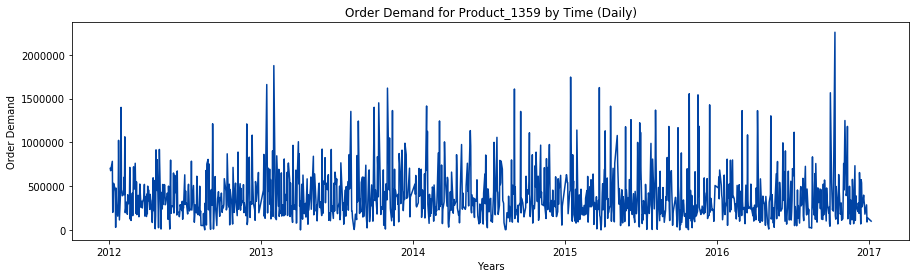

In [9]:
# plotting 
# Plot closing price

register_matplotlib_converters()
plt.figure(figsize=(15, 4))
plt.plot(product, color="#0043A4")
plt.title('Order Demand for Product_1359 by Time (Daily)')
plt.ylabel('Order Demand')
plt.xlabel('Years')
plt.grid(False)
plt.show();

#### Lets plot by summing all the orders values per month for better visualization.

Basically from these kinds of plots, we visualize "trends".

#### Following Observations can be made after looking at the data:

<ul>
<li> As can be seen from the above graphs, data is pretty wild </li>
<li> There may be differences in varients over time </li>
<li> There may be seasonalities, cycles or some ouliers </li>
</ul>

#### Also, the above diagram is kind of messy, let's see if we can do something about that

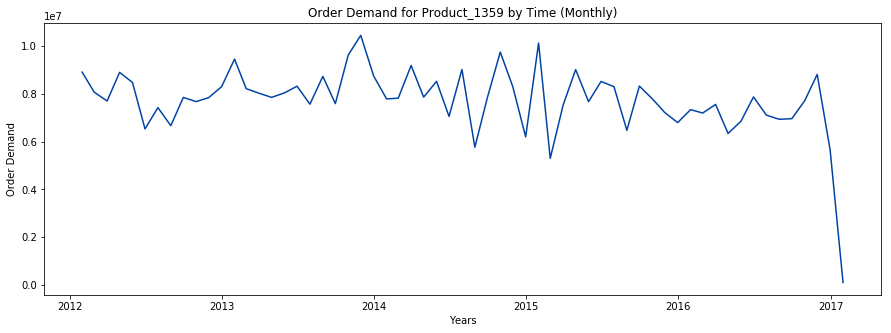

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(product.resample("M").sum(), color="#0043A4")
plt.title('Order Demand for Product_1359 by Time (Monthly)')
plt.ylabel('Order Demand')
plt.xlabel('Years')
plt.grid(False)
plt.show();

#### The above data makes sense as there are a lot less values for the year 2017 and we can actually remove that entree

In [11]:
# Actually We can remove the values for year 2017
product = product.resample("M").sum()
product = product.drop(pd.to_datetime('2017-01-31'));

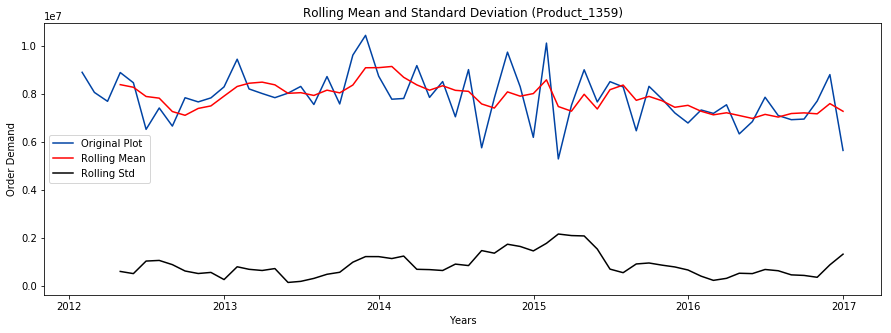

In [12]:
# Now we will determine and plot rolling statistics
# Choosing the size of the rolling window: https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html

plt.figure(figsize=(15, 5))
orignal = plt.plot(product, label="Original Plot", color="#0043A4")
original_mean = plt.plot(product.rolling(window=4).mean(), label="Rolling Mean", color="r")
original_std = plt.plot(product.rolling(window=4).std(), label="Rolling Std", color="black")
plt.title("Rolling Mean and Standard Deviation (Product_1359)")
plt.legend(loc="best")
plt.ylabel('Order Demand')
plt.xlabel('Years')
plt.show(block=False);

#### As seen from above graph, data seem like stationary, as rolling mean and standard deviation seem stationary

In [13]:
# Dickey-Fuller Test
# Ref: http://www.insightsbot.com/blog/1MH61d/augmented-dickey-fuller-test-in-python
#Dickey-Fuller test:
print('Dickey-Fuller Results:')
adfTest = adfuller(product["Order_Demand"], autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','No. of Lags Used','No. of Observations Used'])

#Add Critical Values
for key,value in adfTest[4].items():
    dfResults['Critical Value (%s)'%key] = value
print(dfResults)

Dickey-Fuller Results:
ADF Test Statistic         -7.688952e+00
P-Value                     1.436333e-11
No. of Lags Used            0.000000e+00
No. of Observations Used    5.900000e+01
Critical Value (1%)        -3.546395e+00
Critical Value (5%)        -2.911939e+00
Critical Value (10%)       -2.593652e+00
dtype: float64


As can be seen from the above test, P-Value is close to zero, which is a good indication of stationarity (but the difference between Critical Value (1%) and ADF Test Statistic is large) (ref: https://www.youtube.com/watch?v=e8Yw4alG16Q&t=1245s). Let's check the trends using "decompose".

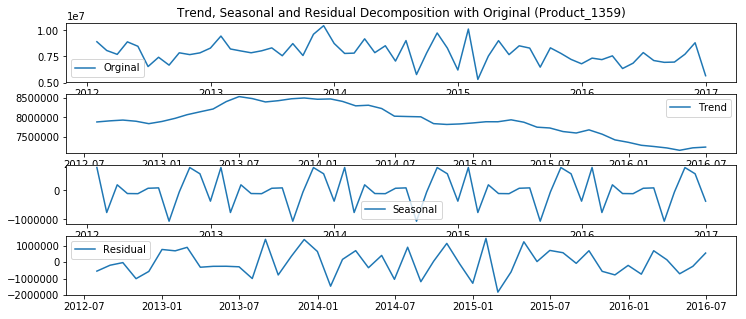

In [14]:
# Ref: https://www.youtube.com/watch?v=e8Yw4alG16Q&t=1245s
decomposition = seasonal_decompose(product)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(12, 5))
plt.subplot(411)
plt.title("Trend, Seasonal and Residual Decomposition with Original (Product_1359)")
plt.plot(product, label="Orginal")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonal")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residual")
plt.legend(loc="best");

### Using Time series forcasting modelling

These models or algorithms assume that, the data is stationary. This means that, it should have constant mean, varience, low outliers, and in general, data should follow constant or general trend from the past. So, in short <b>stationarity</b> is important here.

In [15]:
# We can split the data into test and train data
train = product[:'2015-12-31']
test = product['2016-01-31':]

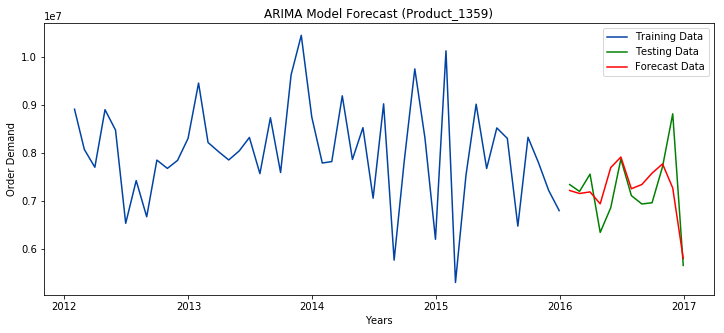

In [17]:
# Using Arima model from statsmodels package
# But, first we have to select correct p,q and r values
# We can adjust these values
# We can also use ACF and PACF plots to correctly predict the value, but I don't want this to be complecated

model = ARIMA(test, order=(0,0,1))
results = model.fit()
# plt.plot(test)
# plt.plot(results.fittedvalues, color="r")
plt.figure(figsize=(12, 5))
plt.plot(train, color='#0043A4', label='Training Data')
plt.title("ARIMA Model Forecast (Product_1359)")
plt.plot(test, color='g', label='Testing Data')
plt.plot(results.fittedvalues, color='r', label='Forecast Data')
plt.ylabel('Order Demand')
plt.xlabel('Years')
plt.legend(loc="best");

The above figure shows ARIMA time series forecasting details